<a href="https://colab.research.google.com/github/malindard/brain-tumor-detection/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
dataset_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/"

def image_gen(height, width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )

    val_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )

    return train_ds, val_ds


def augmented_data(height, width):
    datagen = ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
    )

    train_ds = datagen.flow_from_directory(
        dataset_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )

    return train_ds

train_ds, val_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels])
print('\n\n',{"No brain tumor cases": len(np.where(total_images==0)[0]),
             "Brain tumor cases": len(np.where(total_images==1)[0])})

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


 {'No brain tumor cases': 98, 'Brain tumor cases': 155}


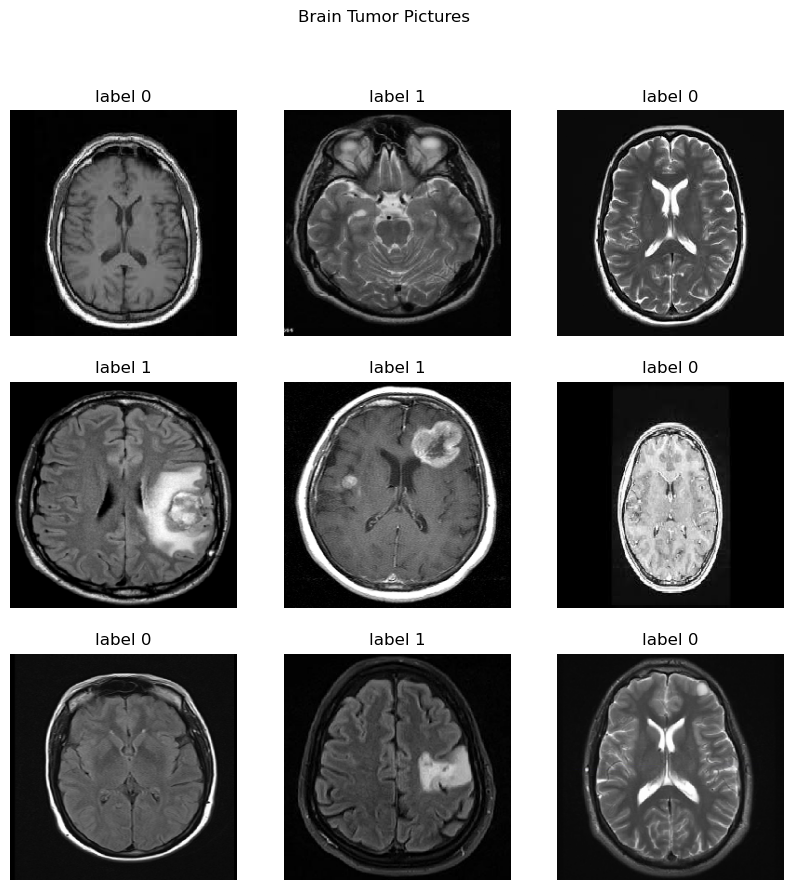

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

# ResNet50V2

Training without data augmentation (compile-nya dengan adam optimizer)

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
#Declaring base model
tf.keras.backend.clear_session()

base_model = ResNet50V2(input_shape=(244,244,3), include_top=False)
base_model.trainable = False

model1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model1.compile(optimizer=Adam(),
               loss="sparse_categorical_crossentropy",
               metrics=['accuracy'])

model1.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 51

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.6749
Epoch 1: accuracy improved from -inf to 0.67488, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 21s 3s/step - loss: 0.7151 - accuracy: 0.6749 - val_loss: 0.3554 - val_accuracy: 0.8200
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8571
Epoch 2: accuracy improved from 0.67488 to 0.85714, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 17s 3s/step - loss: 0.3400 - accuracy: 0.8571 - val_loss: 0.2888 - val_accuracy: 0.9000
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9212
Epoch 3: accuracy improved from 0.85714 to 0.92118, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 17s 3s/step - loss: 0.2184 - accuracy: 0.9212 - val_loss: 0.3802 - val_accuracy: 0.8800
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0

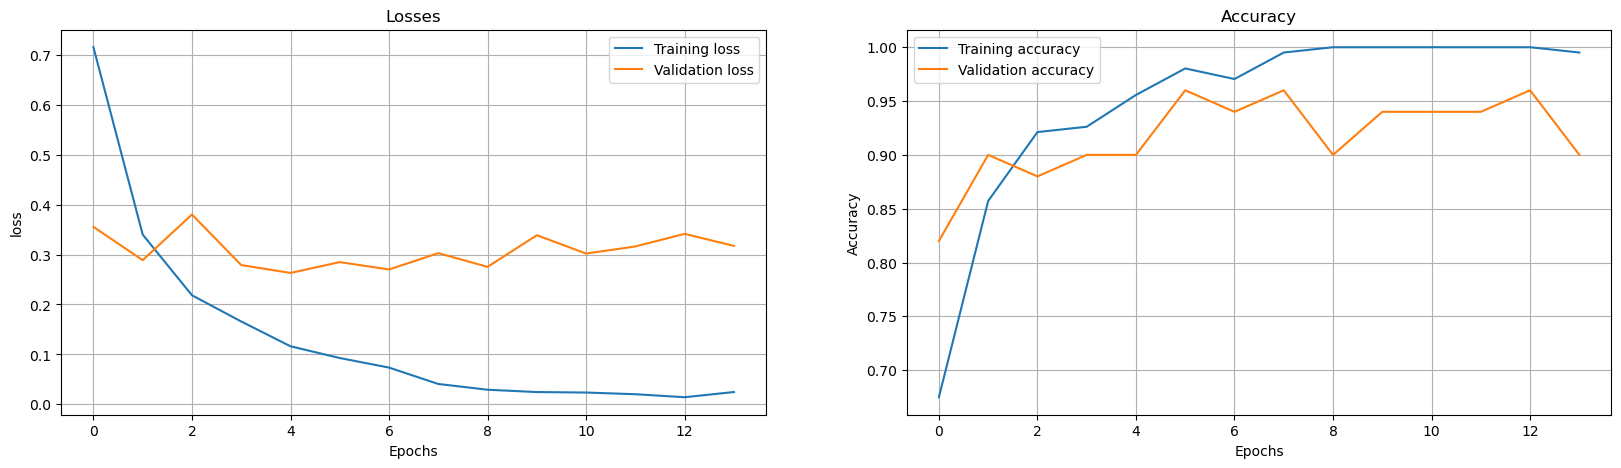

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

Training with augmented data

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                                                 patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 253 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8300
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 22s 3s/step - loss: 0.3882 - accuracy: 0.8300 - val_loss: 0.2012 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.8893
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 21s 3s/step - loss: 0.2625 - accuracy: 0.8893 - val_loss: 0.2757 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9289
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 22s 3s/step - loss: 0.2146 - accuracy: 0.9289 - val_loss: 0.1368 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9051
Epoch 4: accuracy did not impr

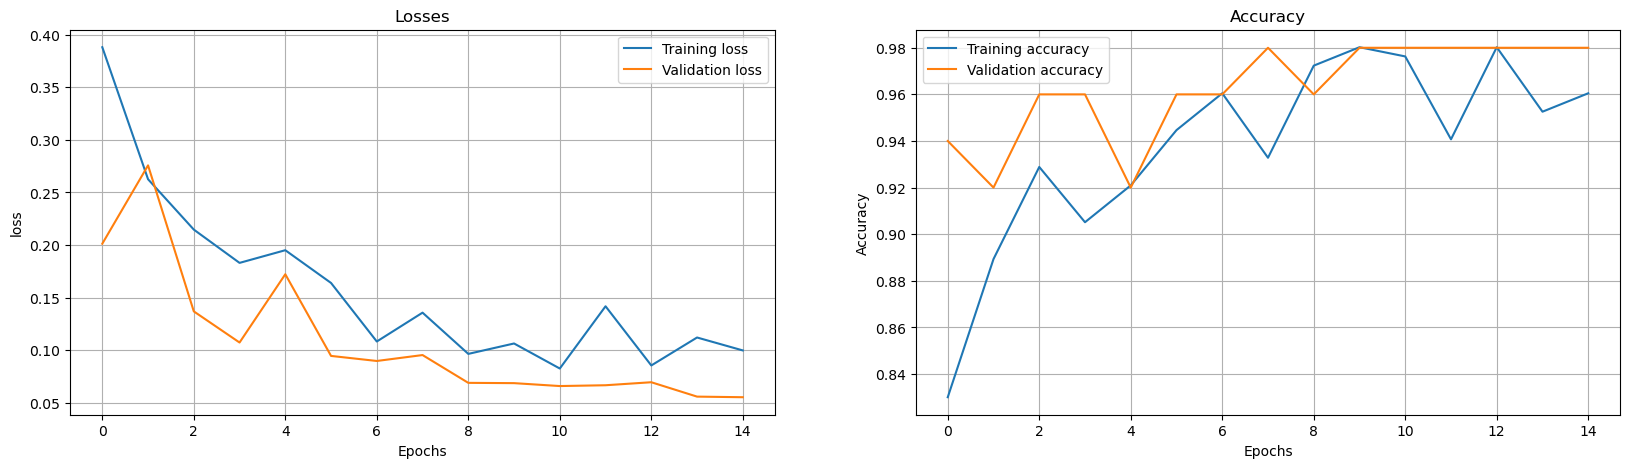

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()


In [ ]:
train_result = model1.evaluate(train_ds)
val_result = model1.evaluate(val_ds)

model1_result = pd.DataFrame(zip(train_result, val_result),
                             columns=['Train', 'Validation'],
                             index=['Loss', "Accuracy"])

model1_result

2/2 [==============================] - 3s 1s/step - loss: 0.0685 - accuracy: 0.9800


,Train,Validation
Loss,0.033992,0.068518
Accuracy,0.995074,0.980000


In [ ]:
y_pred = model1.predict(val_ds[0][0])
y_pred = np.argmax(y_pred, axis=-1)

y_test = val_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 3s 3s/step
Confusion matrix:
 [[11  0]
 [ 1 20]]
Accuracy Score:  0.96875
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.95      1.00      0.98        20

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



<AxesSubplot:>

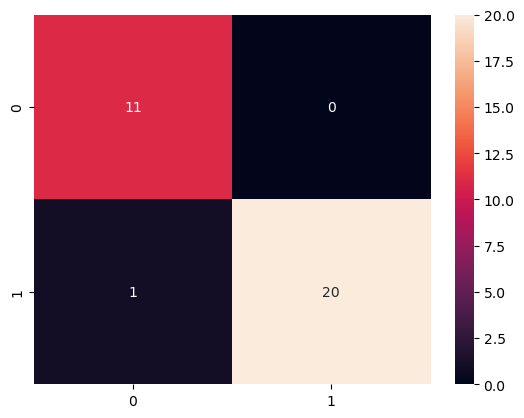

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# VGG19

Training without data augmentation

In [ ]:
from keras.applications.vgg19 import VGG19

tf.keras.backend.clear_session()

#initializing new height and width for images
height=224
width=224

train_ds, val_ds = image_gen(height, width)

base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable = False

model2 = Sequential([
    base_model,
    #GlobalAveragePooling2D(),
    Flatten(),
    #Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model2.compile(loss="binary_crossentropy",
               optimizer=Adam(0.01), metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model2.fit(train_ds,
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 6.3658 - accuracy: 0.6108
Epoch 1: accuracy improved from -inf to 0.61084, saving model to model/vgg19_best.h5
7/7 [==============================] - 60s 9s/step - loss: 6.3658 - accuracy: 0.6108 - val_loss: 2.4532 - val_accuracy: 0.7400
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 1.9392 - accuracy: 0.7488
Epoch 2: accuracy improved from 0.61084 to 0.74877, saving model to model/vgg19_best.h5
7/7 [==============================] - 59s 9s/step - loss: 1.9392 - accuracy: 0.7488 - val_loss: 1.8196 - val_accuracy: 0.7000
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 1.3533 - accuracy: 0.7734
Epoch 3: accuracy improved from 0.74877 to 0.77340, saving model to model/vgg19_best.h5
7/7 [==============================] - 59s 9s/step - loss: 1.3533 - accuracy: 0.7734 - val_loss: 1.4867 - val_accuracy: 0.7200
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.9756 - accurac

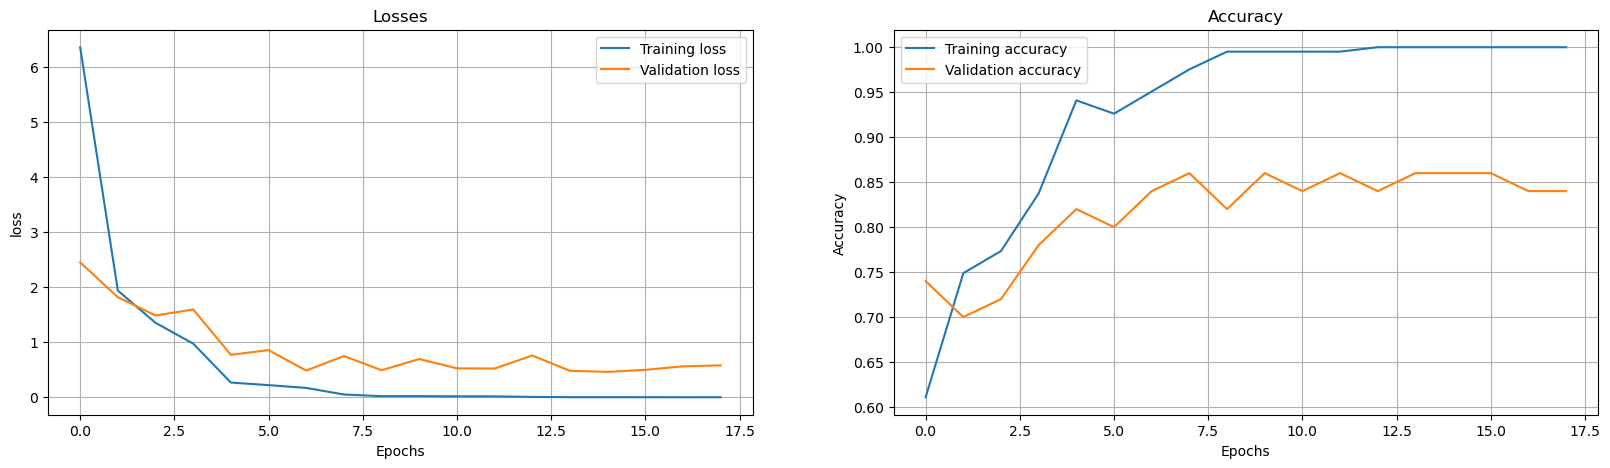

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

Training with augmented data

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy',
                                                 factor=0.3,patience=2,
                                                 min_lr=0.0000001)
callbacks_list = [checkpoint,early, reduce_lr]

history = model2.fit(aug_train_ds,
           validation_data=val_ds,
           epochs=30,
           shuffle=True,
           verbose=True,
           callbacks=callbacks_list
          )

Found 253 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.1117 - accuracy: 0.7668
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 73s 9s/step - loss: 1.1117 - accuracy: 0.7668 - val_loss: 1.5470 - val_accuracy: 0.8200 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.7549
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 73s 9s/step - loss: 1.1305 - accuracy: 0.7549 - val_loss: 0.4331 - val_accuracy: 0.8200 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.8787 - accuracy: 0.8221
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 73s 9s/step - loss: 0.8787 - accuracy: 0.8221 - val_loss: 0.0794 - val_accuracy: 0.9800 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 1.0483 - accuracy: 0.7787
Epoch 4: accuracy did not impr

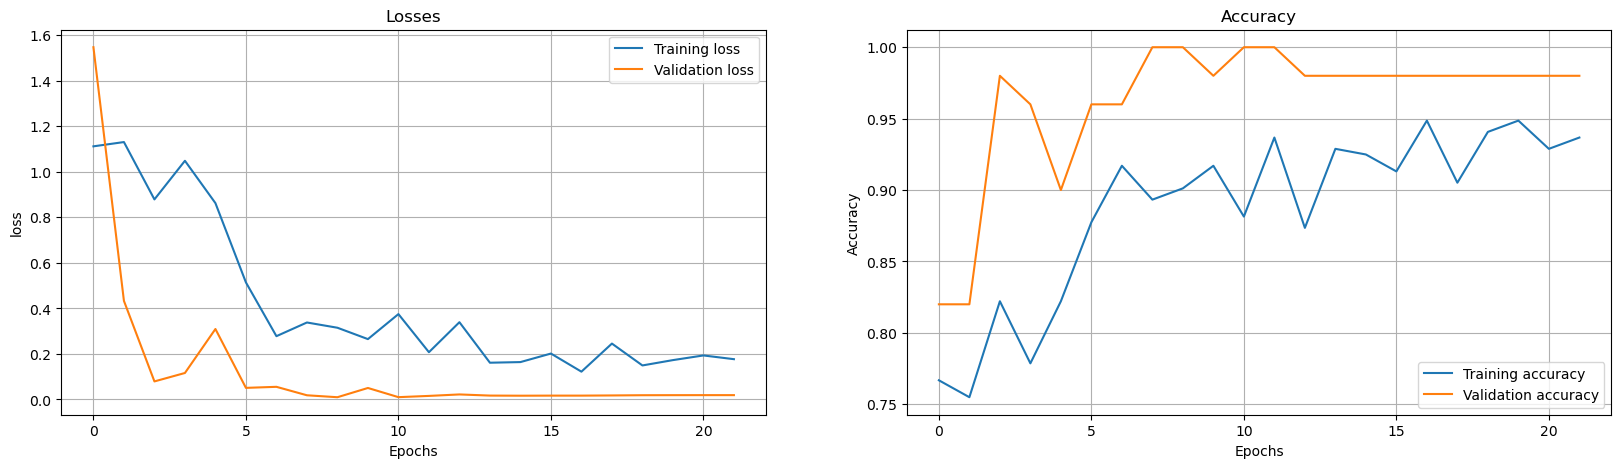

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
train_result = model2.evaluate(train_ds)
val_result = model2.evaluate(val_ds)

model2_result = pd.DataFrame(zip(train_result, val_result),
                             columns=['Train', 'Validation'],
                             index=['Loss', "Accuracy"])

model2_result

2/2 [==============================] - 12s 4s/step - loss: 0.0170 - accuracy: 0.9800


,Train,Validation
Loss,0.005648,0.017027
Accuracy,1.000000,0.980000


In [ ]:
y_pred = model2.predict(val_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = val_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 8s 8s/step
Confusion matrix:
 [[12  0]
 [ 0 20]]
Accuracy Score:  1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        20

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



<AxesSubplot:>

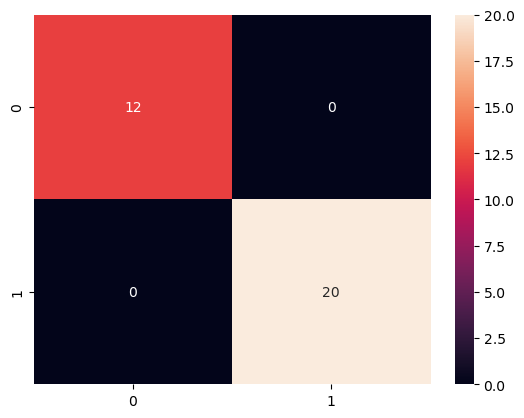

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

# InceptionV3

Training without augmented data

In [ ]:
from keras.applications import InceptionV3

height=299
width=299

train_ds, val_ds = image_gen(height, width)

tf.keras.backend.clear_session()

base_model = InceptionV3(
    input_shape=(height, width,3),
    weights='imagenet',
    include_top=False
)

base_model.trainable = False

model3 = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model3.compile(loss="binary_crossentropy", optimizer=Adam(0.01), metrics=['accuracy'])

model3.summary()

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",
                                         restore_best_weights=True, patience=5)

callback_lsit = [checkpoint, early]

history = model3.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 28.8268 - accuracy: 0.6552
Epoch 1: accuracy improved from -inf to 0.65517, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 25s 3s/step - loss: 28.8268 - accuracy: 0.6552 - val_loss: 21.2557 - val_accuracy: 0.7800
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 9.4685 - accuracy: 0.8571
Epoch 2: accuracy improved from 0.65517 to 0.85714, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 19s 3s/step - loss: 9.4685 - accuracy: 0.8571 - val_loss: 14.8112 - val_accuracy: 0.9200
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 6.7542 - accuracy: 0.9212
Epoch 3: accuracy improved from 0.85714 to 0.92118, saving model to model/inceptionv3_best.h5
7/7 [==============================] - 20s 3s/step - loss: 6.7542 - accuracy: 0.9212 - val_loss: 15.5916 - val_accuracy: 0.8800
Epoch 4/30
7/7 [==============================] - ETA: 0s -

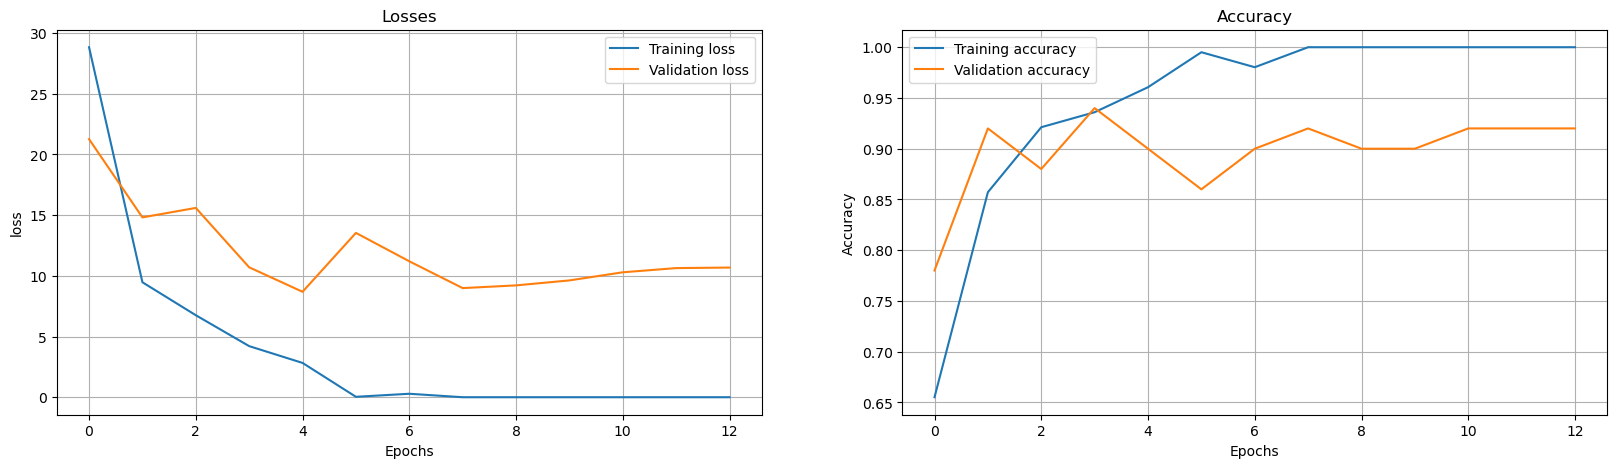

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

Training with augmented data

In [ ]:
aug_train_ds = augmented_data(height, width)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                              patience=3, min_lr=0.0000001)
callback_lsit = [checkpoint, early, reduce_lr]

history = model3.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callback_lsit)

Found 253 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 12.9702 - accuracy: 0.8419
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 26s 3s/step - loss: 12.9702 - accuracy: 0.8419 - val_loss: 9.5143 - val_accuracy: 0.8800 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 6.4863 - accuracy: 0.8656
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 25s 3s/step - loss: 6.4863 - accuracy: 0.8656 - val_loss: 4.3001 - val_accuracy: 0.9400 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 2.5788 - accuracy: 0.9209
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 26s 3s/step - loss: 2.5788 - accuracy: 0.9209 - val_loss: 1.7896 - val_accuracy: 0.9400 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 3.3338 - accuracy: 0.9170
Epoch 4: accuracy did not im

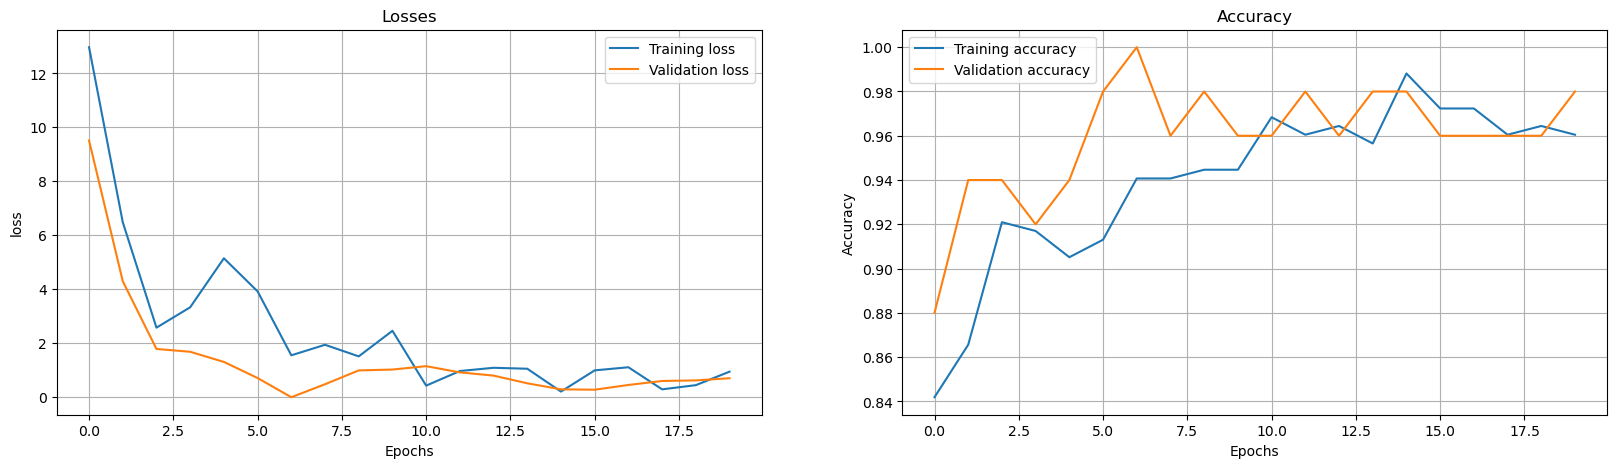

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
train_result = model3.evaluate(train_ds)
val_result = model3.evaluate(val_ds)

model3_result = pd.DataFrame(zip(train_result, val_result),
                             columns=['Train', 'Validation'],
                             index=['Loss', "Accuracy"])

model3_result

2/2 [==============================] - 4s 1s/step - loss: 0.2936 - accuracy: 0.9800


,Train,Validation
Loss,2.203615e-22,0.293613
Accuracy,1.000000e+00,0.980000


In [ ]:
y_pred = model3.predict(val_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = val_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 3s 3s/step
Confusion matrix:
 [[10  0]
 [ 0 22]]
Accuracy Score:  1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        22

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



<AxesSubplot:>

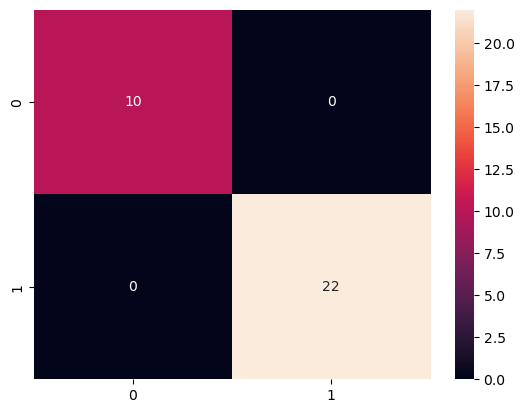

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)